## Feature Selection & ML

In [1]:
import os
import numpy as np
import joblib
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold, train_test_split, ParameterGrid
from sklearn.feature_selection import RFE, SelectKBest, f_classif, VarianceThreshold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix
from sklearn.model_selection import GridSearchCV


# ==== SETTINGS ====
IS_HYPERPARAM_TUNING = True                                                                                 # !!!!!
featuresDirPath = "/Users/wachiii/Workschii/brain-asd/data/data_children/features/30s_epochbasedNew20250526/"    # !!!!!
modelDirForSavelPath = "/Users/wachiii/Workschii/brain-asd/model/newChildren/20250526_singlefeat/"              # !!!!!
OUTLIER_THRESHOLD = 3.0


featuresTypePathDict = {
    "bandpower": "/bandpower/",
    "coherence": "/coherence/",
    "hfd": "/hfd/",
    "relativepower": "/relativepower/",
    "cd": "/cd/", 
    "subbandpower": "/subbandpower/",
    "alphabeta": "/alphabeta/"
}

## Interquatile Range (IQR) Method

Lower (e.g., 1.0 × IQR) → More values considered outliers (stricter).

Higher (e.g., 3.0 × IQR) → Fewer values considered outliers (looser, only extreme ones removed).

In [2]:
def remove_outliers_iqr_3d(data, threshold=3):
    numEpochs, numBands, numChannels = data.shape
    mask = np.ones(numEpochs, dtype=bool)

    for band in range(numBands):
        for ch in range(numChannels):
            values = data[:, band, ch]
            Q1 = np.percentile(values, 25)
            Q3 = np.percentile(values, 75)
            IQR = Q3 - Q1

            lowerBound = Q1 - threshold * IQR
            upperBound = Q3 + threshold * IQR

            mask &= (values >= lowerBound) & (values <= upperBound)

    return data[mask], mask


def remove_outliers_iqr_2d(data, threshold=3):
    numEpochs, numChannels = data.shape
    mask = np.ones(numEpochs, dtype=bool)
    for ch in range(numChannels):
        values = data[:, ch]
        Q1 = np.percentile(values, 25)
        Q3 = np.percentile(values, 75)
        IQR = Q3 - Q1
        lowerBound = Q1 - threshold * IQR
        upperBound = Q3 + threshold * IQR
        mask &= (values >= lowerBound) & (values <= upperBound)
    return data[mask], mask

## Single Feature Type

### 1. Get feature ☁️

In [59]:
# === CHANGE THIS TO SWITCH BETWEEN FEATURE TYPE ===
whichFeatureType = "bandpower"  # "bandpower", "coherence", "hfd", "relativepower" # !!!!
whichDirForModelPath = modelDirForSavelPath + "bandpower"  # "bandpower", "coherence", "hfd", "relativepower" # !!!!
# ==================================================

hcFeaturePath = featuresDirPath + "/" + whichFeatureType + "/" + f"{whichFeatureType}_HC.npy"
asdFeaturePath = featuresDirPath + "/" + whichFeatureType + "/" + f"{whichFeatureType}_ASD.npy"
hcFeatureUnseenPath = featuresDirPath + "/" + whichFeatureType + "/" + f"{whichFeatureType}_HC_unseen.npy"
asdFeatureUnseenPath = featuresDirPath + "/" + whichFeatureType + "/" + f"{whichFeatureType}_ASD_unseen.npy"

hcFeature = np.load(hcFeaturePath)[:, :, :-1]  
asdFeature = np.load(asdFeaturePath)[:, :, :-1]  
hcFeatureUnseen = np.load(hcFeatureUnseenPath)[:, :, :-1]  
asdFeatureUnseen = np.load(asdFeatureUnseenPath)[:, :, :-1]  

# hcFeature = np.load(hcFeaturePath)[:, :-1]  
# asdFeature = np.load(asdFeaturePath)[:, :-1]  
# hcFeatureUnseen = np.load(hcFeatureUnseenPath)[:, :-1]  
# asdFeatureUnseen = np.load(asdFeatureUnseenPath)[:, :-1]  

# Balance unseen data
min_unseen_epochs = min(hcFeatureUnseen.shape[0], asdFeatureUnseen.shape[0])

if hcFeatureUnseen.shape[0] > min_unseen_epochs:
    indices = np.random.choice(hcFeatureUnseen.shape[0], min_unseen_epochs, replace=False)
    hcFeatureUnseen = hcFeatureUnseen[indices]
else:
    indices = np.random.choice(asdFeatureUnseen.shape[0], min_unseen_epochs, replace=False)
    asdFeatureUnseen = asdFeatureUnseen[indices]

# Print the updated shapes
print(f"hcFeature shape: {hcFeature.shape}")
print(f"asdFeature shape: {asdFeature.shape}")
print(f"hcFeatureUnseen shape: {hcFeatureUnseen.shape}")
print(f"asdFeatureUnseen shape: {asdFeatureUnseen.shape}")

hcFeature shape: (486, 5, 19)
asdFeature shape: (486, 5, 19)
hcFeatureUnseen shape: (126, 5, 19)
asdFeatureUnseen shape: (126, 5, 19)


### 2. Outlier Removal 🍂

In [60]:
hcFeature, hcMask = remove_outliers_iqr_3d(hcFeature, OUTLIER_THRESHOLD)
asdFeature, mddMask = remove_outliers_iqr_3d(asdFeature, OUTLIER_THRESHOLD)
print(f"hcFeature shape after outlier removal: {hcFeature.shape}")
print(f"mddFeature shape after outlier removal: {asdFeature.shape}")

min_size = min(hcFeature.shape[0], asdFeature.shape[0])
if hcFeature.shape[0] > min_size:
    indices = np.random.choice(hcFeature.shape[0], min_size, replace=False)
    hcFeature = hcFeature[indices]
else:
    indices = np.random.choice(asdFeature.shape[0], min_size, replace=False)
    asdFeature = asdFeature[indices] 
    
print(f"hcFeature shape after balancing: {hcFeature.shape}")
print(f"asdFeature shape after balancing: {asdFeature.shape}")

hcFeature shape after outlier removal: (325, 5, 19)
mddFeature shape after outlier removal: (307, 5, 19)
hcFeature shape after balancing: (307, 5, 19)
asdFeature shape after balancing: (307, 5, 19)


In [61]:
# from joblib import load


# bestModelPath = "/Users/wachiii/Workschii/brain-asd/model/adult/20250513_Eyeopen_SingleFeat_balancedUnseen/bandpower/Decision Tree_NoFeatureSelection/model_fold_3.pkl"
# model = load(bestModelPath)

# frequency_bands = ['delta', 'theta', 'alpha', 'beta', 'gamma']
# channels = [
#     'Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2',
#     'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz'
# ]

# feature_labels = [f"{band}_{ch}" for band in frequency_bands for ch in channels]

# importances = model.feature_importances_

# # Check shape consistency
# assert len(importances) == len(feature_labels), "Mismatch in number of features!"

# # Pair features with their importances
# feature_importance = list(zip(feature_labels, importances))

# # Sort by importance
# feature_importance.sort(key=lambda x: x[1], reverse=True)

# # Convert to numpy array for easy indexing
# feature_importance = np.array(feature_importance)

# # Plot top 20 features
# top_n = 20
# top_features = feature_importance[:top_n, 0]
# top_scores = feature_importance[:top_n, 1].astype(float)

# plt.figure(figsize=(10, 6))
# sns.barplot(x=top_scores, y=top_features, palette="viridis")
# plt.xlabel("Feature Importance")
# plt.ylabel("EEG Feature")
# plt.title(f"Top {top_n} Important Features from Decision Tree")
# plt.savefig("top20_feature_importance_adult_eyeopen.png", dpi=800,  transparent=True)
# plt.tight_layout()
# plt.show()

### 3. Prepare Feature 🍳

In [62]:
hcFeature = hcFeature.reshape(hcFeature.shape[0], -1)
asdFeature = asdFeature.reshape(asdFeature.shape[0], -1)
hcFeatureUnseen = hcFeatureUnseen.reshape(hcFeatureUnseen.shape[0], -1)
asdFeatureUnseen = asdFeatureUnseen.reshape(asdFeatureUnseen.shape[0], -1)



In [63]:
X_train = np.concatenate((hcFeature, asdFeature), axis=0)
y_train = np.concatenate((np.zeros(hcFeature.shape[0]), np.ones(asdFeature.shape[0])), axis=0)

X_test = np.concatenate((hcFeatureUnseen, asdFeatureUnseen), axis=0)
y_test = np.concatenate((np.zeros(hcFeatureUnseen.shape[0]), np.ones(asdFeatureUnseen.shape[0])), axis=0)

### 4. Train Models 🍛

In [64]:
models = {
    "KNN": (KNeighborsClassifier(), {"n_neighbors": [3, 5, 7, 9, 11], "weights": ["uniform", "distance"]}),
    "Decision Tree": (DecisionTreeClassifier(), {"max_depth": [5, 10, 15, 20]}),
    "Random Forest": (RandomForestClassifier(), {"n_estimators": [10, 50, 100, 150], "max_depth": [10, 20, 30], "min_samples_leaf": [1, 2, 4]}),
    "Logistic Regression": (LogisticRegression(), {"C": [0.01, 0.1, 1], "solver": ["liblinear", "saga"]}),
    "Gradient Boosting": (GradientBoostingClassifier(), {"n_estimators": [50, 100], "learning_rate": [0.01, 0.1, 0.2, 0.25, 0.3], "min_samples_leaf": [1, 2, 4]}),
    "AdaBoost": (AdaBoostClassifier(), {"n_estimators": [50, 100], "learning_rate": [0.01, 0.1, 0.5, 1]}),
}

featureSelectors = {
    "NoFeatureSelection": None
}

def get_stratified_kfold_data(X, y, nSplits=5):
    skf = StratifiedKFold(n_splits=nSplits, shuffle=True, random_state=42)
    return skf.split(X, y)

Training KNN with NoFeatureSelection...


Best hyperparameters for KNN: {'n_neighbors': 5, 'weights': 'distance'}
Best fold: 1 with ACC score: 0.9355
Training Decision Tree with NoFeatureSelection...
Best hyperparameters for Decision Tree: {'max_depth': 5}
Best fold: 5 with ACC score: 0.9344
Training Random Forest with NoFeatureSelection...
Best hyperparameters for Random Forest: {'max_depth': 30, 'min_samples_leaf': 2, 'n_estimators': 150}
Best fold: 3 with ACC score: 0.9839
Training Logistic Regression with NoFeatureSelection...


/Users/wachiii/miniconda3/envs/base-ml/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/wachiii/miniconda3/envs/base-ml/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/wachiii/miniconda3/envs/base-ml/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/wachiii/miniconda3/envs/base-ml/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/wachiii/miniconda3/envs/base-ml/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  

Best hyperparameters for Logistic Regression: {'C': 0.1, 'solver': 'liblinear'}
Best fold: 8 with ACC score: 1.0000
Training Gradient Boosting with NoFeatureSelection...
Best hyperparameters for Gradient Boosting: {'learning_rate': 0.1, 'min_samples_leaf': 2, 'n_estimators': 100}
Best fold: 5 with ACC score: 1.0000
Training AdaBoost with NoFeatureSelection...
Best hyperparameters for AdaBoost: {'learning_rate': 1, 'n_estimators': 100}
Best fold: 1 with ACC score: 0.9839

KNN with NoFeatureSelection - Final evaluation
Final Accuracy: 0.7579
Final Precision: 0.7642
Final Recall: 0.7460
Final F1 Score: 0.7550
Best Hyperparameters: {'n_neighbors': 5, 'weights': 'distance'}
Hyperparameter Tuning Details: [{'params': {'n_neighbors': 3, 'weights': 'uniform'}, 'mean_test_score': np.float64(0.6726642676262828), 'std_test_score': np.float64(0.06355073177008289)}, {'params': {'n_neighbors': 3, 'weights': 'distance'}, 'mean_test_score': np.float64(0.6742902838864453), 'std_test_score': np.float64(

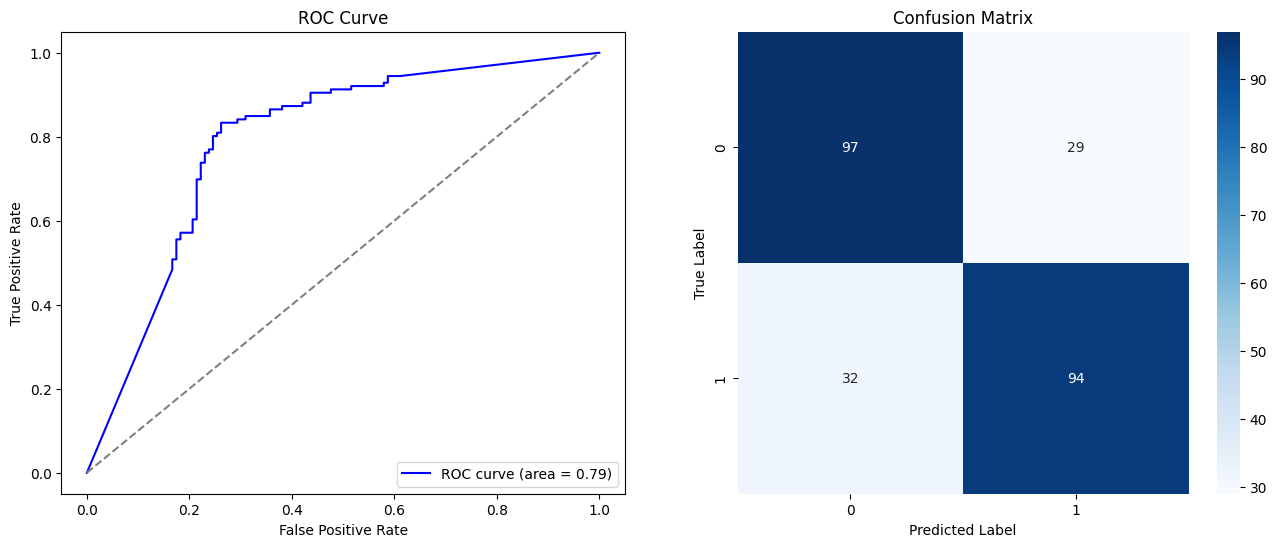

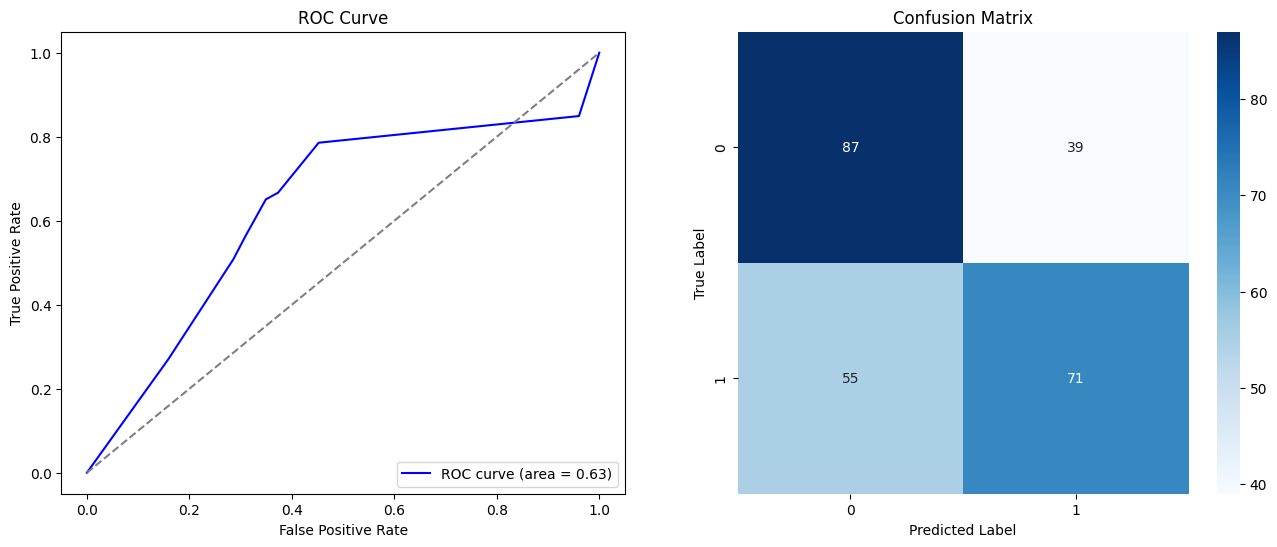

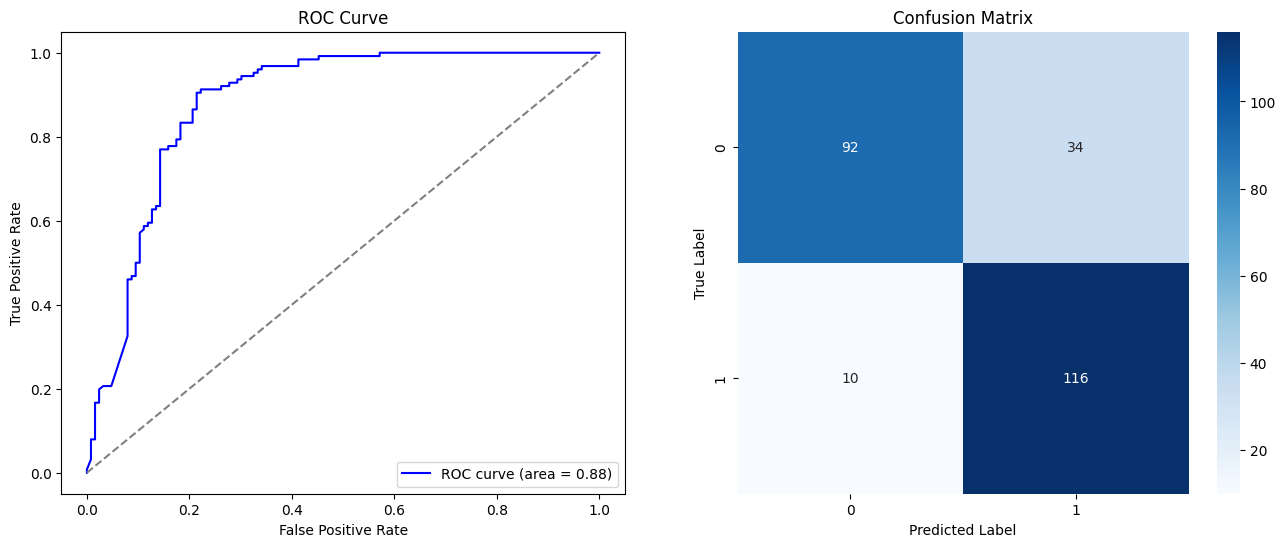

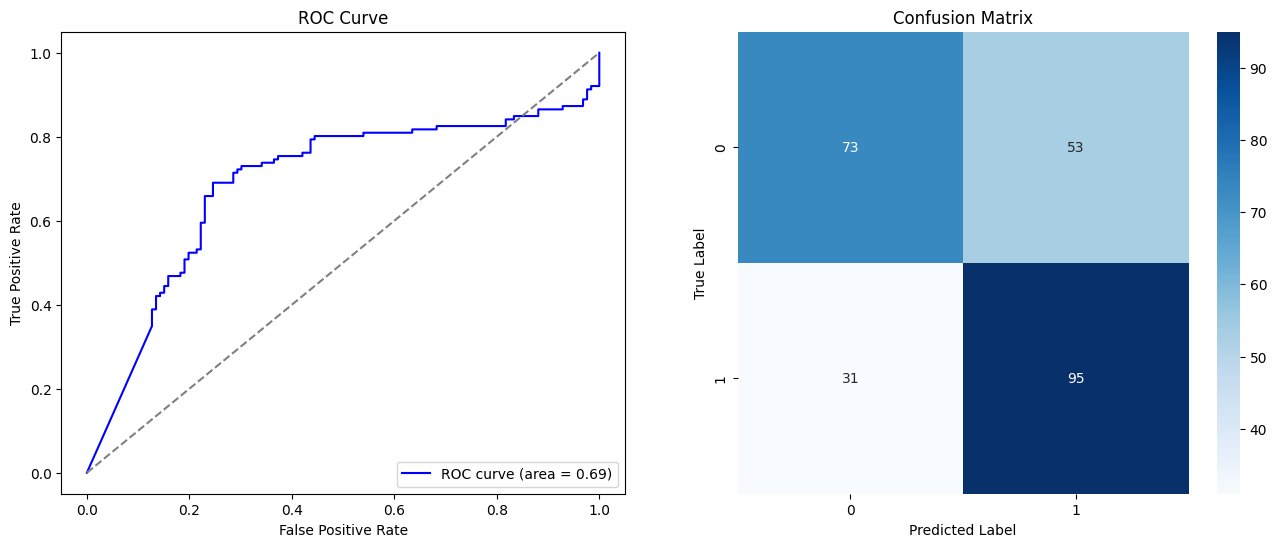

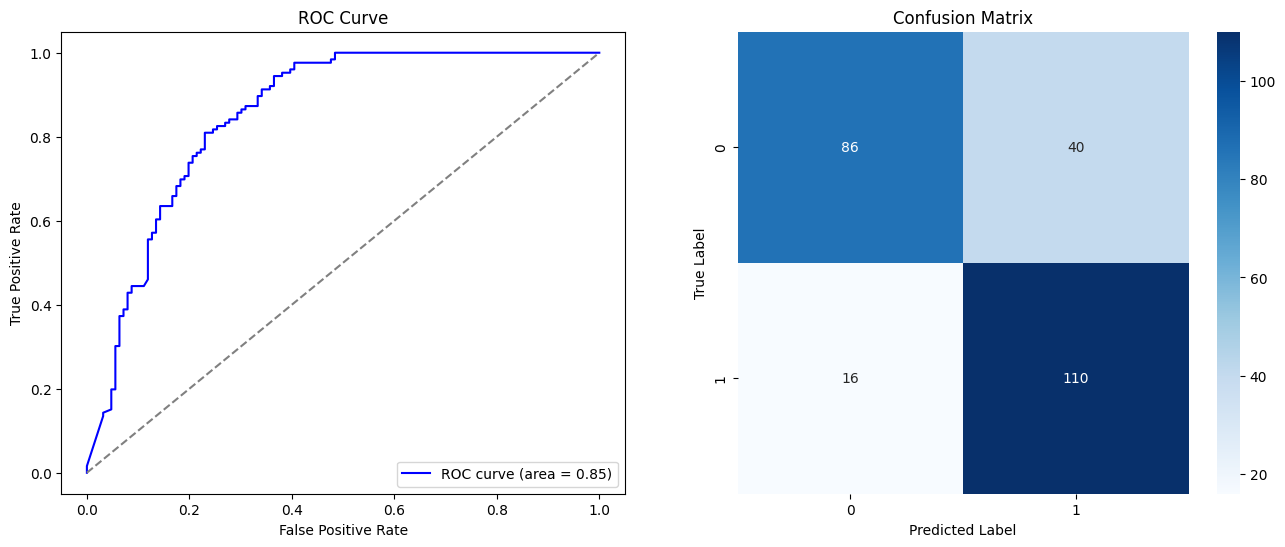

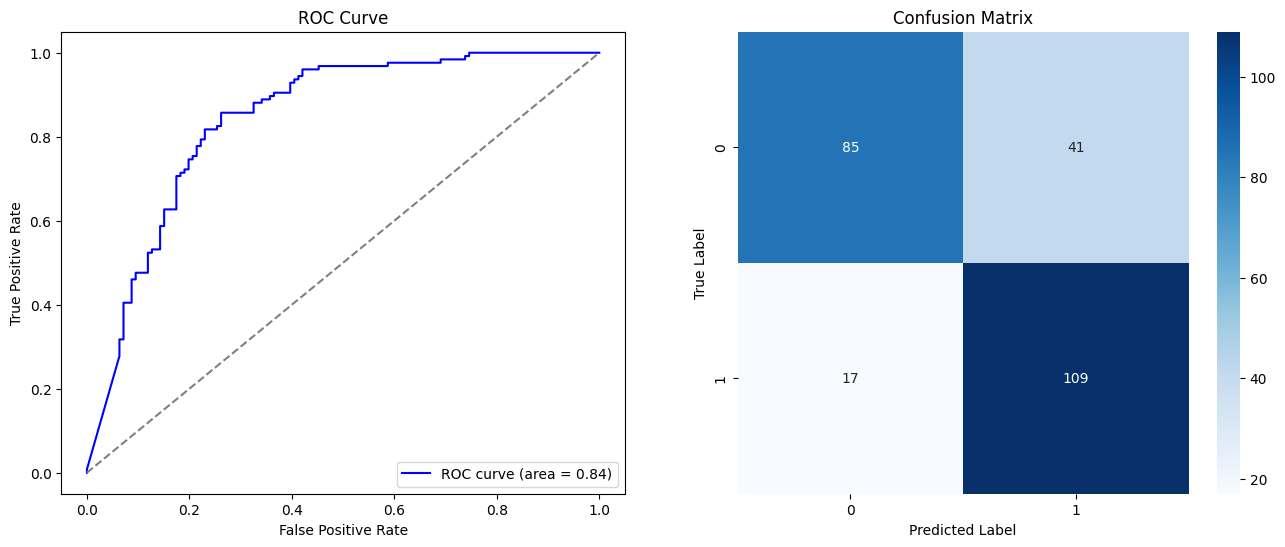

In [65]:
results = []

for modelName, (model, paramGrid) in models.items():
    for featureSelectorName, featureSelector in featureSelectors.items():
        print(f"Training {modelName} with {featureSelectorName}...")
        if featureSelector is not None:
            selector = featureSelector
        else:
            selector = None
        skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
        bestFold = None
        bestAcc = -np.inf
        bestFoldModel = None
        bestFoldIdx = None
        hyperparamTuningDetails = []  

        if IS_HYPERPARAM_TUNING and paramGrid:
            gridSearch = GridSearchCV(model, paramGrid, cv=5, scoring="accuracy", n_jobs=8, return_train_score=True)
            gridSearch.fit(X_train, y_train)
            model = gridSearch.best_estimator_
            bestParams = gridSearch.best_params_
            print(f"Best hyperparameters for {modelName}: {bestParams}")

            for i, params in enumerate(gridSearch.cv_results_["params"]):
                meanTestScore = gridSearch.cv_results_["mean_test_score"][i]
                stdTestScore = gridSearch.cv_results_["std_test_score"][i]
                hyperparamTuningDetails.append({
                    "params": params,
                    "mean_test_score": meanTestScore,
                    "std_test_score": stdTestScore
                })
        else:
            bestParams = None

        foldAccuracies = []
        foldPrecisions = []
        foldRecalls = []
        foldF1Scores = []
        selectedFeatures = []
        foldHcTrain = []
        foldMddTrain = []
        foldHcVal = []
        foldMddVal = []
        foldHcTest = []
        foldMddTest = []

        for fold, (trainIdx, valIdx) in enumerate(skf.split(X_train, y_train)):
            XTrain, XVal = X_train[trainIdx], X_train[valIdx]
            yTrain, yVal = y_train[trainIdx], y_train[valIdx]

            hcTrain = int(np.sum(yTrain == 0))
            mddTrain = int(np.sum(yTrain == 1))
            hcVal = int(np.sum(yVal == 0))
            mddVal = int(np.sum(yVal == 1))
            hcTest = int(np.sum(y_test == 0))
            mddTest = int(np.sum(y_test == 1))

            foldHcTrain.append(hcTrain)
            foldMddTrain.append(mddTrain)
            foldHcVal.append(hcVal)
            foldMddVal.append(mddVal)
            foldHcTest.append(hcTest)
            foldMddTest.append(mddTest)

            if selector is not None:
                XTrain = selector.fit_transform(XTrain, yTrain)
                XVal = XVal[:, selector.get_support()]

            model.fit(XTrain, yTrain)

            yPred = model.predict(XVal)
            acc = accuracy_score(yVal, yPred)
            prec = precision_score(yVal, yPred)
            rec = recall_score(yVal, yPred)
            f1 = f1_score(yVal, yPred)

            foldAccuracies.append(float(acc))
            foldPrecisions.append(float(prec))
            foldRecalls.append(float(rec))
            foldF1Scores.append(float(f1))

            if selector is not None:
                selectedFeatures.append(np.where(selector.get_support())[0].tolist())

            modelDir = os.path.join(whichDirForModelPath, f"{modelName}_{featureSelectorName}")
            if not os.path.exists(modelDir):
                os.makedirs(modelDir)
            modelFilename = os.path.join(modelDir, f"model_fold_{fold + 1}.pkl")
            joblib.dump(model, modelFilename)

            if acc > bestAcc:
                bestAcc = acc
                bestFold = model
                bestFoldIdx = fold

        print(f"Best fold: {bestFoldIdx + 1} with ACC score: {bestAcc:.4f}")

        if selector is not None:
            X_train_selected = selector.fit_transform(X_train, y_train)
            X_test_selected = X_test[:, selector.get_support()]
        else:
            X_train_selected = X_train
            X_test_selected = X_test

        bestFold.fit(X_train_selected, y_train)
        yTestPred = bestFold.predict(X_test_selected)
        finalAccuracy = accuracy_score(y_test, yTestPred)
        finalPrecision = precision_score(y_test, yTestPred)
        finalRecall = recall_score(y_test, yTestPred)
        finalF1 = f1_score(y_test, yTestPred)

        yProb = bestFold.predict_proba(X_test_selected)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, yProb)
        roc_auc = auc(fpr, tpr)
        fig_roc, ax_roc = plt.subplots(figsize=(8, 6))
        ax_roc.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
        ax_roc.plot([0, 1], [0, 1], color='gray', linestyle='--')
        ax_roc.set_xlabel('False Positive Rate')
        ax_roc.set_ylabel('True Positive Rate')
        ax_roc.set_title('ROC Curve')
        ax_roc.legend(loc='lower right')
        roc_plot_filename = os.path.join(whichDirForModelPath, f"{modelName}_{whichFeatureType}_roc.png")
        plt.savefig(roc_plot_filename, dpi=800)
        plt.close(fig_roc)

        cm = confusion_matrix(y_test, yTestPred)
        fig_cm, ax_cm = plt.subplots(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True, ax=ax_cm)  
        ax_cm.set_xlabel('Predicted Label')
        ax_cm.set_ylabel('True Label')
        ax_cm.set_title('Confusion Matrix')
        cm_plot_filename = os.path.join(whichDirForModelPath, f"{modelName}_{whichFeatureType}_cm.png")
        plt.savefig(cm_plot_filename, dpi=800)
        plt.close(fig_cm)
        
        fig, ax = plt.subplots(1, 2, figsize=(16, 6))
        ax[0].plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
        ax[0].plot([0, 1], [0, 1], color='gray', linestyle='--')
        ax[0].set_xlabel('False Positive Rate')
        ax[0].set_ylabel('True Positive Rate')
        ax[0].set_title('ROC Curve')
        ax[0].legend(loc='lower right')
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True, ax=ax[1])  # Added cbar=True for color bar
        ax[1].set_xlabel('Predicted Label')
        ax[1].set_ylabel('True Label')
        ax[1].set_title('Confusion Matrix')
        combined_plot_filename = os.path.join(whichDirForModelPath, f"{modelName}_{whichFeatureType}_roc_cm_combined.png")
        plt.savefig(combined_plot_filename, dpi=800)

        results.append({
            "model": modelName,
            "feature_selection": featureSelectorName,
            "avg_accuracy": f"{np.mean(foldAccuracies):.4f} ± {np.std(foldAccuracies):.4f}",
            "avg_precision": f"{np.mean(foldPrecisions):.4f} ± {np.std(foldPrecisions):.4f}",
            "avg_recall": f"{np.mean(foldRecalls):.4f} ± {np.std(foldRecalls):.4f}",
            "avg_f1_score": f"{np.mean(foldF1Scores):.4f} ± {np.std(foldF1Scores):.4f}",
            "final_accuracy": f"{finalAccuracy:.4f}",
            "final_precision": f"{finalPrecision:.4f}",
            "final_recall": f"{finalRecall:.4f}",
            "final_f1_score": f"{finalF1:.4f}",
            "significant_features": np.unique([item for sublist in selectedFeatures for item in sublist]).tolist(),
            "folds_accuracy": foldAccuracies,
            "folds_precision": foldPrecisions,
            "folds_recall": foldRecalls,
            "folds_f1_score": foldF1Scores,
            "fold_hc_train": [int(x) for x in foldHcTrain], 
            "fold_mdd_train": [int(x) for x in foldMddTrain],  
            "fold_hc_val": [int(x) for x in foldHcVal], 
            "fold_mdd_val": [int(x) for x in foldMddVal],  
            "fold_hc_test": [int(x) for x in foldHcTest],  
            "fold_mdd_test": [int(x) for x in foldMddTest],
            "best_fold": bestFoldIdx + 1,
            "best_hyperparameters": bestParams,
            "hyperparam_tuning_details": hyperparamTuningDetails
        })

resultsDf = pd.DataFrame(results)
resultsDf.to_csv(os.path.join(whichDirForModelPath, "results.csv"), index=False)
resultsDf.to_excel(os.path.join(whichDirForModelPath, "results.xlsx"), index=False)

for result in results:
    print(f"\n{result['model']} with {result['feature_selection']} - Final evaluation")
    print(f"Final Accuracy: {result['final_accuracy']}")
    print(f"Final Precision: {result['final_precision']}")
    print(f"Final Recall: {result['final_recall']}")
    print(f"Final F1 Score: {result['final_f1_score']}")
    if result["best_hyperparameters"]:
        print(f"Best Hyperparameters: {result['best_hyperparameters']}")
    if result["hyperparam_tuning_details"]:
        print(f"Hyperparameter Tuning Details: {result['hyperparam_tuning_details']}")

## All Features (Fused)

### 1. Get data ☁️

In [15]:
# === CHANGE THIS TO SWITCH BETWEEN FEATURE TYPE ===
whichDirForModelPath = modelDirForSavelPath + "allFeatures"       # !!!!!

featureTypes = ['bandpower','relativepower']
featuresPathDict = {}

for featureType in featureTypes:
    featuresPathDict[featureType] = {
        "hc": os.path.join(featuresDirPath, featureType, f"{featureType}_HC.npy"),
        "asd": os.path.join(featuresDirPath, featureType, f"{featureType}_ASD.npy"),
        "hc_unseen": os.path.join(featuresDirPath, featureType, f"{featureType}_HC_unseen.npy"),
        "asd_unseen": os.path.join(featuresDirPath, featureType, f"{featureType}_ASD_unseen.npy")
    }
    
hcFeatures = []
asdFeatures = []
hcFeaturesUnseen = []
asdFeaturesUnseen = []  

for featureType, paths in featuresPathDict.items():
    if featureType == "hfd":
        hcFeature = np.load(paths["hc"])[:, :-1]  
        asdFeature = np.load(paths["asd"])[:, :-1]  
        hcFeatureUnseen = np.load(paths["hc_unseen"])[:, :-1]  
        asdFeatureUnseen = np.load(paths["asd_unseen"])[:, :-1]
    else:        
        hcFeature = np.load(paths["hc"])[:, :, :-1]  
        asdFeature = np.load(paths["asd"])[:, :, :-1]  
        hcFeatureUnseen = np.load(paths["hc_unseen"])[:, :, :-1]  
        asdFeatureUnseen = np.load(paths["asd_unseen"])[:, :, :-1]

    # Balance unseen data
    min_unseen_epochs = min(hcFeatureUnseen.shape[0], asdFeatureUnseen.shape[0])

    if hcFeatureUnseen.shape[0] > min_unseen_epochs:
        indices = np.random.choice(hcFeatureUnseen.shape[0], min_unseen_epochs, replace=False)
        hcFeatureUnseen = hcFeatureUnseen[indices]
    else:
        indices = np.random.choice(asdFeatureUnseen.shape[0], min_unseen_epochs, replace=False)
        asdFeatureUnseen = asdFeatureUnseen[indices]

    hcFeatures.append(hcFeature)
    asdFeatures.append(asdFeature)
    hcFeaturesUnseen.append(hcFeatureUnseen)
    asdFeaturesUnseen.append(asdFeatureUnseen)
    
for i, featureType in enumerate(featureTypes):
    print(f"{featureType} hcFeature shape: {hcFeatures[i].shape}")
    print(f"{featureType} asdFeature shape: {asdFeatures[i].shape}")
    print(f"{featureType} hcFeatureUnseen shape: {hcFeaturesUnseen[i].shape}")
    print(f"{featureType} asdFeatureUnseen shape: {asdFeaturesUnseen[i].shape}")

bandpower hcFeature shape: (522, 5, 19)
bandpower asdFeature shape: (522, 5, 19)
bandpower hcFeatureUnseen shape: (90, 5, 19)
bandpower asdFeatureUnseen shape: (90, 5, 19)
relativepower hcFeature shape: (522, 5, 19)
relativepower asdFeature shape: (522, 5, 19)
relativepower hcFeatureUnseen shape: (90, 5, 19)
relativepower asdFeatureUnseen shape: (90, 5, 19)


In [16]:
outlierRemovedFeatures = {}
outlierMasks = {}

for i, featureType in enumerate(featureTypes):
    if featureType == "hfd":
        hcFeature, hcMask = remove_outliers_iqr_2d(hcFeatures[i], OUTLIER_THRESHOLD)
        asdFeature, mddMask = remove_outliers_iqr_2d(asdFeatures[i], OUTLIER_THRESHOLD)
        hcFeatureUnseen, hcUnseenMask = remove_outliers_iqr_2d(hcFeaturesUnseen[i], OUTLIER_THRESHOLD)
        asdFeatureUnseen, asdUnseenMask = remove_outliers_iqr_2d(asdFeaturesUnseen[i], OUTLIER_THRESHOLD)
    else:
        hcFeature, hcMask = remove_outliers_iqr_3d(hcFeatures[i], OUTLIER_THRESHOLD)
        asdFeature, mddMask = remove_outliers_iqr_3d(asdFeatures[i], OUTLIER_THRESHOLD)
        hcFeatureUnseen, hcUnseenMask = remove_outliers_iqr_3d(hcFeaturesUnseen[i], OUTLIER_THRESHOLD)
        asdFeatureUnseen, asdUnseenMask = remove_outliers_iqr_3d(asdFeaturesUnseen[i], OUTLIER_THRESHOLD)

    outlierRemovedFeatures[f"hc{featureType.capitalize()}"] = hcFeature
    outlierRemovedFeatures[f"asd{featureType.capitalize()}"] = asdFeature
    outlierRemovedFeatures[f"hc{featureType.capitalize()}Unseen"] = hcFeatureUnseen
    outlierRemovedFeatures[f"asd{featureType.capitalize()}Unseen"] = asdFeatureUnseen

    outlierMasks[f"hc{featureType.capitalize()}Mask"] = hcMask
    outlierMasks[f"asd{featureType.capitalize()}Mask"] = mddMask
    outlierMasks[f"hc{featureType.capitalize()}UnseenMask"] = hcUnseenMask
    outlierMasks[f"asd{featureType.capitalize()}UnseenMask"] = asdUnseenMask
    
for key, value in outlierRemovedFeatures.items():
    print(f"{key} shape after outlier removal: {value.shape}")

hcBandpower shape after outlier removal: (350, 5, 19)
asdBandpower shape after outlier removal: (344, 5, 19)
hcBandpowerUnseen shape after outlier removal: (48, 5, 19)
asdBandpowerUnseen shape after outlier removal: (64, 5, 19)
hcRelativepower shape after outlier removal: (440, 5, 19)
asdRelativepower shape after outlier removal: (379, 5, 19)
hcRelativepowerUnseen shape after outlier removal: (61, 5, 19)
asdRelativepowerUnseen shape after outlier removal: (67, 5, 19)


In [17]:
concatenatedFeatures = {}
concatenatedUnseenFeatures = {}

# Concatenate features after outlier removal
for featureType in featureTypes:
    if featureType == "hfd":
        hcFeature = outlierRemovedFeatures[f"hc{featureType.capitalize()}"]
        asdFeature = outlierRemovedFeatures[f"asd{featureType.capitalize()}"]
        hcFeatureUnseen = outlierRemovedFeatures[f"hc{featureType.capitalize()}Unseen"]
        asdFeatureUnseen = outlierRemovedFeatures[f"asd{featureType.capitalize()}Unseen"]
    else:
        hcFeature = outlierRemovedFeatures[f"hc{featureType.capitalize()}"].reshape(outlierRemovedFeatures[f"hc{featureType.capitalize()}"].shape[0], -1)
        asdFeature = outlierRemovedFeatures[f"asd{featureType.capitalize()}"].reshape(outlierRemovedFeatures[f"asd{featureType.capitalize()}"].shape[0], -1)
        hcFeatureUnseen = outlierRemovedFeatures[f"hc{featureType.capitalize()}Unseen"].reshape(outlierRemovedFeatures[f"hc{featureType.capitalize()}Unseen"].shape[0], -1)
        asdFeatureUnseen = outlierRemovedFeatures[f"asd{featureType.capitalize()}Unseen"].reshape(outlierRemovedFeatures[f"asd{featureType.capitalize()}Unseen"].shape[0], -1)

    concatenatedFeatures[featureType] = np.concatenate((hcFeature, asdFeature), axis=0)
    concatenatedUnseenFeatures[featureType] = np.concatenate((hcFeatureUnseen, asdFeatureUnseen), axis=0)
    
for featureType in featureTypes:
    print(f"concatenated {featureType} hcFeature shape: {concatenatedFeatures[featureType].shape}")
    print(f"concatenated {featureType} asdFeature shape: {concatenatedFeatures[featureType].shape}")
    print(f"concatenated {featureType} hcFeatureUnseen shape: {concatenatedUnseenFeatures[featureType].shape}")
    print(f"concatenated {featureType} asdFeatureUnseen shape: {concatenatedUnseenFeatures[featureType].shape}") 


min_size = min(concatenatedFeatures[featureTypes[0]].shape[0], concatenatedFeatures[featureTypes[1]].shape[0])
for featureType in featureTypes:
    if concatenatedFeatures[featureType].shape[0] > min_size:
        indices = np.random.choice(concatenatedFeatures[featureType].shape[0], min_size, replace=False)
        concatenatedFeatures[featureType] = concatenatedFeatures[featureType][indices]
    else:
        indices = np.random.choice(concatenatedFeatures[featureType].shape[0], min_size, replace=False)
        concatenatedFeatures[featureType] = concatenatedFeatures[featureType][indices]
        
for featureType in featureTypes:
    print(f"concatenated {featureType} hcFeature shape after balancing: {concatenatedFeatures[featureType].shape}")
    print(f"concatenated {featureType} asdFeature shape after balancing: {concatenatedFeatures[featureType].shape}")
    print(f"concatenated {featureType} hcFeatureUnseen shape after balancing: {concatenatedUnseenFeatures[featureType].shape}")
    print(f"concatenated {featureType} asdFeatureUnseen shape after balancing: {concatenatedUnseenFeatures[featureType].shape}")

concatenated bandpower hcFeature shape: (694, 95)
concatenated bandpower asdFeature shape: (694, 95)
concatenated bandpower hcFeatureUnseen shape: (112, 95)
concatenated bandpower asdFeatureUnseen shape: (112, 95)
concatenated relativepower hcFeature shape: (819, 95)
concatenated relativepower asdFeature shape: (819, 95)
concatenated relativepower hcFeatureUnseen shape: (128, 95)
concatenated relativepower asdFeatureUnseen shape: (128, 95)
concatenated bandpower hcFeature shape after balancing: (694, 95)
concatenated bandpower asdFeature shape after balancing: (694, 95)
concatenated bandpower hcFeatureUnseen shape after balancing: (112, 95)
concatenated bandpower asdFeatureUnseen shape after balancing: (112, 95)
concatenated relativepower hcFeature shape after balancing: (694, 95)
concatenated relativepower asdFeature shape after balancing: (694, 95)
concatenated relativepower hcFeatureUnseen shape after balancing: (128, 95)
concatenated relativepower asdFeatureUnseen shape after balan

### 3. Prepare Feature 🍳

In [18]:
min_hc_samples = min(
    concatenatedFeatures["bandpower"].shape[0],
    concatenatedFeatures["relativepower"].shape[0]
)

min_asd_samples = min(
    concatenatedFeatures["bandpower"].shape[0],
    concatenatedFeatures["relativepower"].shape[0]
)

for key in ["bandpower", "relativepower"]:
    concatenatedFeatures[key] = concatenatedFeatures[key][:min_hc_samples]
    concatenatedFeatures[key] = concatenatedFeatures[key][:min_asd_samples]

for key in concatenatedFeatures.keys():
    if len(concatenatedFeatures[key].shape) == 3:
        concatenatedFeatures[key] = concatenatedFeatures[key].reshape(concatenatedFeatures[key].shape[0], -1)

hcFeatures = np.concatenate(
    [concatenatedFeatures["bandpower"],  concatenatedFeatures["relativepower"]], axis=1
)

asdFeatures = np.concatenate(
    [concatenatedFeatures["bandpower"], concatenatedFeatures["relativepower"]], axis=1
)

print(f"hcFeatures shape: {hcFeatures.shape}")
print(f"asdFeatures shape: {asdFeatures.shape}")

min_size = min(hcFeatures.shape[0], asdFeatures.shape[0])
if hcFeatures.shape[0] > min_size:
    indices = np.random.choice(hcFeatures.shape[0], min_size, replace=False)
    hcFeatures = hcFeatures[indices]
else:
    indices = np.random.choice(asdFeatures.shape[0], min_size, replace=False)
    asdFeatures = asdFeatures[indices]

print(f"hcFeatures shape after balancing: {hcFeatures.shape}")
print(f"asdFeatures shape after balancing: {asdFeatures.shape}")

hcFeatures shape: (694, 190)
asdFeatures shape: (694, 190)
hcFeatures shape after balancing: (694, 190)
asdFeatures shape after balancing: (694, 190)


In [19]:
min_hc_unseen_samples = min(
    concatenatedUnseenFeatures["bandpower"].shape[0],
    concatenatedUnseenFeatures["relativepower"].shape[0]
)

min_asd_unseen_samples = min(
    concatenatedUnseenFeatures["bandpower"].shape[0],
    concatenatedUnseenFeatures["relativepower"].shape[0]
)

for key in ["bandpower", "relativepower"]:
    concatenatedUnseenFeatures[key] = concatenatedUnseenFeatures[key][:min_hc_unseen_samples]
    concatenatedUnseenFeatures[key] = concatenatedUnseenFeatures[key][:min_asd_unseen_samples]

for key in concatenatedUnseenFeatures.keys():
    if len(concatenatedUnseenFeatures[key].shape) == 3:
        concatenatedUnseenFeatures[key] = concatenatedUnseenFeatures[key].reshape(concatenatedUnseenFeatures[key].shape[0], -1)

hcUnseenFeatures = np.concatenate(
    [concatenatedUnseenFeatures["bandpower"],  concatenatedUnseenFeatures["relativepower"]], axis=1
)

asdUnseenFeatures = np.concatenate(
    [concatenatedUnseenFeatures["bandpower"],  concatenatedUnseenFeatures["relativepower"]], axis=1
)

print(f"hcUnseenFeatures shape: {hcUnseenFeatures.shape}")
print(f"asdUnseenFeatures shape: {asdUnseenFeatures.shape}")
print(f"hcUnseenFeatures shape after balancing: {hcUnseenFeatures.shape}")
print(f"asdUnseenFeatures shape after balancing: {asdUnseenFeatures.shape}")

hcUnseenFeatures shape: (112, 190)
asdUnseenFeatures shape: (112, 190)
hcUnseenFeatures shape after balancing: (112, 190)
asdUnseenFeatures shape after balancing: (112, 190)


In [20]:
X_train = np.concatenate((hcFeatures, asdFeatures), axis=0)
y_train = np.concatenate((np.zeros(hcFeatures.shape[0]), np.ones(asdFeatures.shape[0])), axis=0)
X_test = np.concatenate((hcUnseenFeatures, asdUnseenFeatures), axis=0)
y_test = np.concatenate((np.zeros(hcUnseenFeatures.shape[0]), np.ones(asdUnseenFeatures.shape[0])), axis=0)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (1388, 190)
y_train shape: (1388,)
X_test shape: (224, 190)
y_test shape: (224,)


### 4. Train Models 🍛

In [21]:
models = {
    "KNN": (KNeighborsClassifier(), {"n_neighbors": [3, 5, 7, 9, 11], "weights": ["uniform", "distance"]}),
    "Decision Tree": (DecisionTreeClassifier(), {"max_depth": [5, 10, 15, 20]}),
    "Random Forest": (RandomForestClassifier(), {"n_estimators": [10, 50, 100, 150], "max_depth": [10, 20, 30], "min_samples_leaf": [1, 2, 4]}),
    "Logistic Regression": (LogisticRegression(), {"C": [0.01, 0.1, 1], "solver": ["liblinear", "saga"]}),
    "Gradient Boosting": (GradientBoostingClassifier(), {"n_estimators": [50, 100], "learning_rate": [0.01, 0.1, 0.2, 0.25, 0.3], "min_samples_leaf": [1, 2, 4]}),
    "AdaBoost": (AdaBoostClassifier(), {"n_estimators": [50, 100], "learning_rate": [0.01, 0.1, 0.5, 1]}),
}

featureSelectors = {
    "NoFeatureSelection": None,
    "SelectKBest": SelectKBest(score_func=f_classif, k=100)
}

def get_stratified_kfold_data(X, y, nSplits=5):
    skf = StratifiedKFold(n_splits=nSplits, shuffle=True, random_state=42)
    return skf.split(X, y)